# Using pseudotime (DPT) to check the gene expression dynamics

- Last updated: 11/2/2023
- Author: Yang-Joon Kim

- We will use the CellOracle's default pseudotime result (Diffusion-based Pseudotime) to visualize the gene expression dynamics for the set of genes detected by network motifs.

- motif 38 (Feed-Forward Loop) - can be split into coherent and incoherent
- motif 46 (positive Feedback Loop)

In [1]:
import time
import os
import shutil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
import celloracle as co
from celloracle.applications import Pseudotime_calculator
co.__version__

/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str

'0.14.0'

In [3]:
oracle_TDR118 = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/10_TDR118_pseudotime.celloracle.oracle")
oracle_TDR118

Oracle object

Meta data
    celloracle version used for instantiation: 0.14.0
    n_cells: 13022
    n_genes: 3000
    cluster_name: predicted.id
    dimensional_reduction_name: X_atac.umap.cellranger
    n_target_genes_in_TFdict: 12674 genes
    n_regulatory_in_TFdict: 863 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 316 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1637 genes
    k_for_knn_imputation: 325
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Done

In [6]:
oracle_TDR118.adata.obs["Pseudotime_Lineage_Meso"].head()

AAACAGCCACCTAAGC-1         NaN
AAACAGCCAGGGAGGA-1    0.166715
AAACAGCCATAGACCC-1    0.096022
AAACATGCAAACTCAT-1         NaN
AAACATGCAAGGACCA-1         NaN
Name: Pseudotime_Lineage_Meso, dtype: float64

In [ ]:
oracle_TDR118.adata.obs["Pseudotime_Lineage_Meso"].head()

In [12]:
oracle_TDR118.adata.obs["Lineage_Meso"]

AAACAGCCACCTAAGC-1    False
AAACAGCCAGGGAGGA-1     True
AAACAGCCATAGACCC-1     True
AAACATGCAAACTCAT-1    False
AAACATGCAAGGACCA-1    False
                      ...  
TTTGTTGGTCGACTCC-1    False
TTTGTTGGTGATTTGG-1    False
TTTGTTGGTTCACCCA-1    False
TTTGTTGGTTCGGGAT-1    False
TTTGTTGGTTTGTGGA-1     True
Name: Lineage_Meso, Length: 13022, dtype: category
Categories (2, object): ['False', 'True']

In [16]:
adata_lineage_meso = oracle_TDR118.adata[oracle_TDR118.adata.obs["Lineage_Meso"]=="True"]
adata_lineage_meso

View of AnnData object with n_obs × n_vars = 3359 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'predicted.id', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_annotation', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'SCT.weight', 'peaks_celltype.weight', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'Lineage_Meso', 'Lineage_NeuroEcto', 'Pseudotime_Lineage_Meso', 'Pseudotime_Lineage_NeuroEcto', 'Pseudotime'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators', 'isin_actve_regulators'
    uns: 'hvg', 'predicted.id_colors', 'log1p'
    obsm: 'X_atac.umap', 'X_atac.umap.cellranger', 'X_umap', 'X_umap.pca30', 'X_wnn.umap'
    layers: 'raw_count', 'normalized_count', 'imputed_count', 'simulation_

In [17]:
adata_lineage_meso.obs["Pseudotime_Lineage_Meso"]

AAACAGCCAGGGAGGA-1    0.166715
AAACAGCCATAGACCC-1    0.096022
AAACATGCAGGACCTT-1    0.123974
AAACATGCATAGGCGA-1    0.166604
AAACCGAAGATAAAGC-1    0.184109
                        ...   
TTTGTGAAGGGTTAGA-1    0.094620
TTTGTGGCATGTCAAT-1    0.093617
TTTGTGTTCGCTAAGT-1    0.338374
TTTGTTGGTAGGTGTC-1    0.328998
TTTGTTGGTTTGTGGA-1    0.189805
Name: Pseudotime_Lineage_Meso, Length: 3359, dtype: float64

In [20]:
# Sort the AnnData object based on pseudotime
adata_lineage_meso = adata_lineage_meso[adata_lineage_meso.obs['Pseudotime_Lineage_Meso'].argsort()]
adata_lineage_meso.obs

# filter out the last one, which has "inf" for the pseudotime value
adata_lineage_meso = adata_lineage_meso[:-1,:]

list_reg_TFs = ['etv4','hmga1a','nr2f5','tbx16','meis1a',
                'meis1b','sox6','hoxb3a','sox5','foxc1a',
                'uncx','foxp4','en2b','rarga','nr2f1b',
                'alx4a','elk3','pax6b','vsx1','dlx3b']

In [23]:
adata_lineage_meso.layers["normalized_count"].todense()

<3358x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 585203 stored elements in Compressed Sparse Row format>

In [24]:
count_matrice = pd.DataFrame(data=adata_lineage_meso.layers["normalized_count"].todense(),
                             index=adata_lineage_meso.obs_names,
                             columns=adata_lineage_meso.var_names)
count_matrice

,msgn1,BX649468.1,ripply2,chrm2a,FAR2,phlda1,pde3a,CU928073.1,cd9b,ntf3,...,fibina,rbl2,irx5b,irx3b,urahb,igl4v10,NC-002333.17,mt-co2,mt-atp6,mt-co3
AATCATGTCGATTTGA-1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,3.871201,3.091042,2.639057,2.833213
GCCACAATCATGCGTG-1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,4.276666,3.970292,3.784190,3.637586
GAGGCTTGTGTGTGGT-1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,4.691348,3.526361,3.258097,3.135494
AAAGGTTAGGAGCAAC-1,1.609438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.693147,0.0,0.0,0.000000,0.0,0.0,3.912023,3.761200,3.332205,3.688879
AGCACTTAGCTCCTTA-1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,3.367296,2.639057,1.945910,2.639057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGCTCTCAGGGCCATC-1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,4.934474,4.343805,4.007333,4.382027
ATGGCTTAGGAAGCAC-1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,3.688879,5.056246,4.510860,4.727388
CTCGTTATCTAGCGAT-1,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.693147,0.0,0.0,4.644391,4.709530,4.553877,4.912655
TCCTCAATCGCTTGCT-1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,4.948760,4.204693,3.828641,3.988984


In [42]:
plt.scatter(adata_lineage_meso.obs['Pseudotime_Lineage_Meso'].to_list(), 
                count_matrice[gene].to_list())
plt.show()

In [48]:
%matplotlib inline
from scipy.interpolate import make_interp_spline

Gene foxc1a is not in the dataset


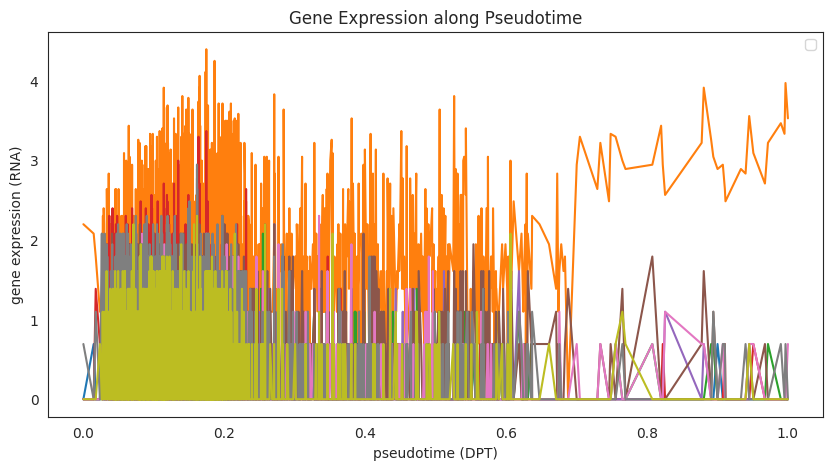

In [51]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Loop through the list of genes and plot their expression values
for gene in list_reg_TFs[0:10]:
    if gene in adata_lineage_meso.var_names:
        
        x_sorted = adata_lineage_meso.obs['Pseudotime_Lineage_Meso'].to_list()
        y_sorted = count_matrice[gene].to_list()
        
#         # Interpolate to get a smooth curve
#         spline = make_interp_spline(x_sorted, y_sorted, k=3)  # k is the degree of the spline
#         x_smooth = np.linspace(x_sorted.min(), x_sorted.max(), 100)
#         y_smooth = spline(x_smooth)
        
        plt.plot(x_sorted, y_sorted)
#         plt.plot(adata_lineage_meso.obs['Pseudotime_Lineage_Meso'].to_list(), 
#                       count_matrice[gene].to_list())
    else:
        print(f"Gene {gene} is not in the dataset")

# Adding labels and title
ax.set_xlabel('pseudotime (DPT)')
ax.set_ylabel('gene expression (RNA)')
ax.set_title('Gene Expression along Pseudotime')
ax.legend()

# Show the plot
plt.show()

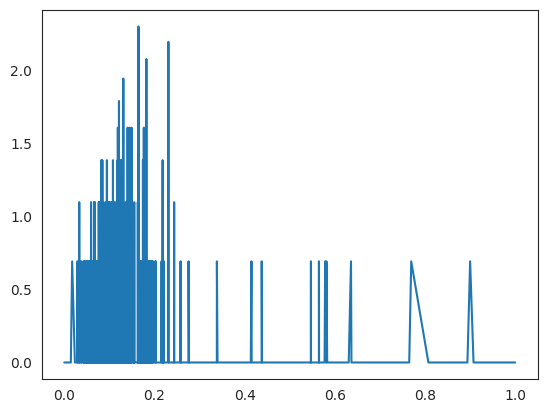

In [52]:
# gene_name
gene = "myf5"
x_sorted = adata_lineage_meso.obs['Pseudotime_Lineage_Meso'].to_list()
y_sorted = count_matrice[gene].to_list()

plt.plot(x_sorted, y_sorted)

In [ ]:
# pt = Pseudotime_calculator(oracle_object=oracle_TDR118)
# pt

In [ ]:
oracle_TDR118_simulated = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/13_TDR118_pseudotime_KOsimulated.celloracle.oracle")
oracle_TDR118_simulated

In [ ]:
oracle_TDR118_simulated.get_mcmc_cell_transition_table()